In [65]:
import re
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split


pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format
# 지수 표기법 해제

# 데이터 탐색

In [2]:
raw_data = pd.read_csv("vehicles.csv")

### 결측치 확인

In [3]:
def columns_na_percentage(columns):
    for column in columns:
        print("{} : ".format(column),round(100 -(len(raw_data['{}'.format(column)].dropna()) / len(raw_data)) * 100,2),"%", end='\n')

In [18]:
columns_na_percentage(raw_data.columns)

id :  0.0 %
url :  0.0 %
region :  0.0 %
region_url :  0.0 %
price :  0.0 %
year :  0.3 %
manufacturer :  4.47 %
model :  1.57 %
condition :  45.52 %
cylinders :  39.19 %
fuel :  0.78 %
odometer :  18.12 %
title_status :  0.6 %
transmission :  0.73 %
vin :  40.71 %
drive :  28.29 %
size :  67.12 %
type :  27.77 %
paint_color :  32.32 %
image_url :  0.0 %
description :  0.0 %
county :  100.0 %
state :  0.0 %
lat :  2.02 %
long :  2.02 %


In [5]:
msno.matrix(raw_data)

### 제외 컬럼
- 예측에 도움이 되지 않는 데이터
  - 'url','region_url','vin','image_url','description'
- 위치정보
  - 'lat','long'
 
- 주관적 데이터
  - condition
- 기타
  - 'model' : 카테고리 너무 많음
  - 'county' : 전부 null
  - 'id : 주문별 고유값
  - 'size' : 결측치 50% 이상

In [196]:
raw_data.shape

(509577, 25)

In [3]:
start_df = raw_data[['id','price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders','model','vin']]

### 결측치 제거

In [4]:
start_df = start_df.dropna(axis=0)
start_df.shape

(120082, 15)

In [5]:
start_df = start_df.loc[start_df['vin'].drop_duplicates(keep='last').index]
start_df.shape

(77339, 15)

- 고유값 : id, vin
- 종속변수 : 가격(price)
- 독립변수
  - 카테고리 : 
    - 연료(fuel)
    - 실린더(cylinder)
    - 변속기(transmission)
    - 구동 방식(drive)
    - 차량 크기(size)
    - 색깔(paint_color)
    - 차량 상태(title_status)
    - 차량 타입(type)
    - 제조사(manufacturer)
    - 연식(year)
  - 실수형 
       주행거리(odometer)

### 종속 변수의 특성

- 도메인지식 으로 확인 가능한 아웃라이어
    -  1~9까지 연속되는 숫자를 자릿수에 상관없이 지운다.
    -  한숫자가 반복되는 숫자를 자릿수에 상관없이 지운다.
  -  100만불 초과 삭제
  -  100불 이하 삭제 (0불 포함)

### 종속 변수 범위 설정

In [190]:
# 100불 이하, 100만불 이상 삭제
df = start_df[(start_df['price'] > 100) & (start_df['price'] <= 1000000)]

# 특정 패턴 숫자 제거
n = ""
for j in range(1,10):
    root_num = float(str(1)*j)
    for i in range(1,10):
        df = df[df['price'] != root_num * i]

for g in range(1,10):
    n =""
    for k in range(g,10):
        k = str(k)
        n += k
        df = df[df['price'] != float(n)]

    for m in range(1,9):
        if n[m:]:
            if n[m:] not in n[m:]:
                df = df[df['price'] != float(n[m:])]

    
for h in range(9,1,-1):
    n = ""
    for k in range(h,0,-1):
        k = str(k)
        n += k
        df = df[df['price'] != float(n)]
    for m in range(1,9):
        if n[m:]:
            if n[m:] not in n[m:]:
                df = df[df['price'] != float(n[m:])]

                # 독립변수 
# 2021년, 0년
df = df[(df['year'] != 2021) & (df['year'] != 0)]

# 주행거리 100 이하, 1000000만 이상, 
df = df[(df["odometer"] >= 100) & (df["odometer"] <= 1000000)]

df.shape

(71061, 15)

### 독립 변수의 특성

### 연식

## 가격

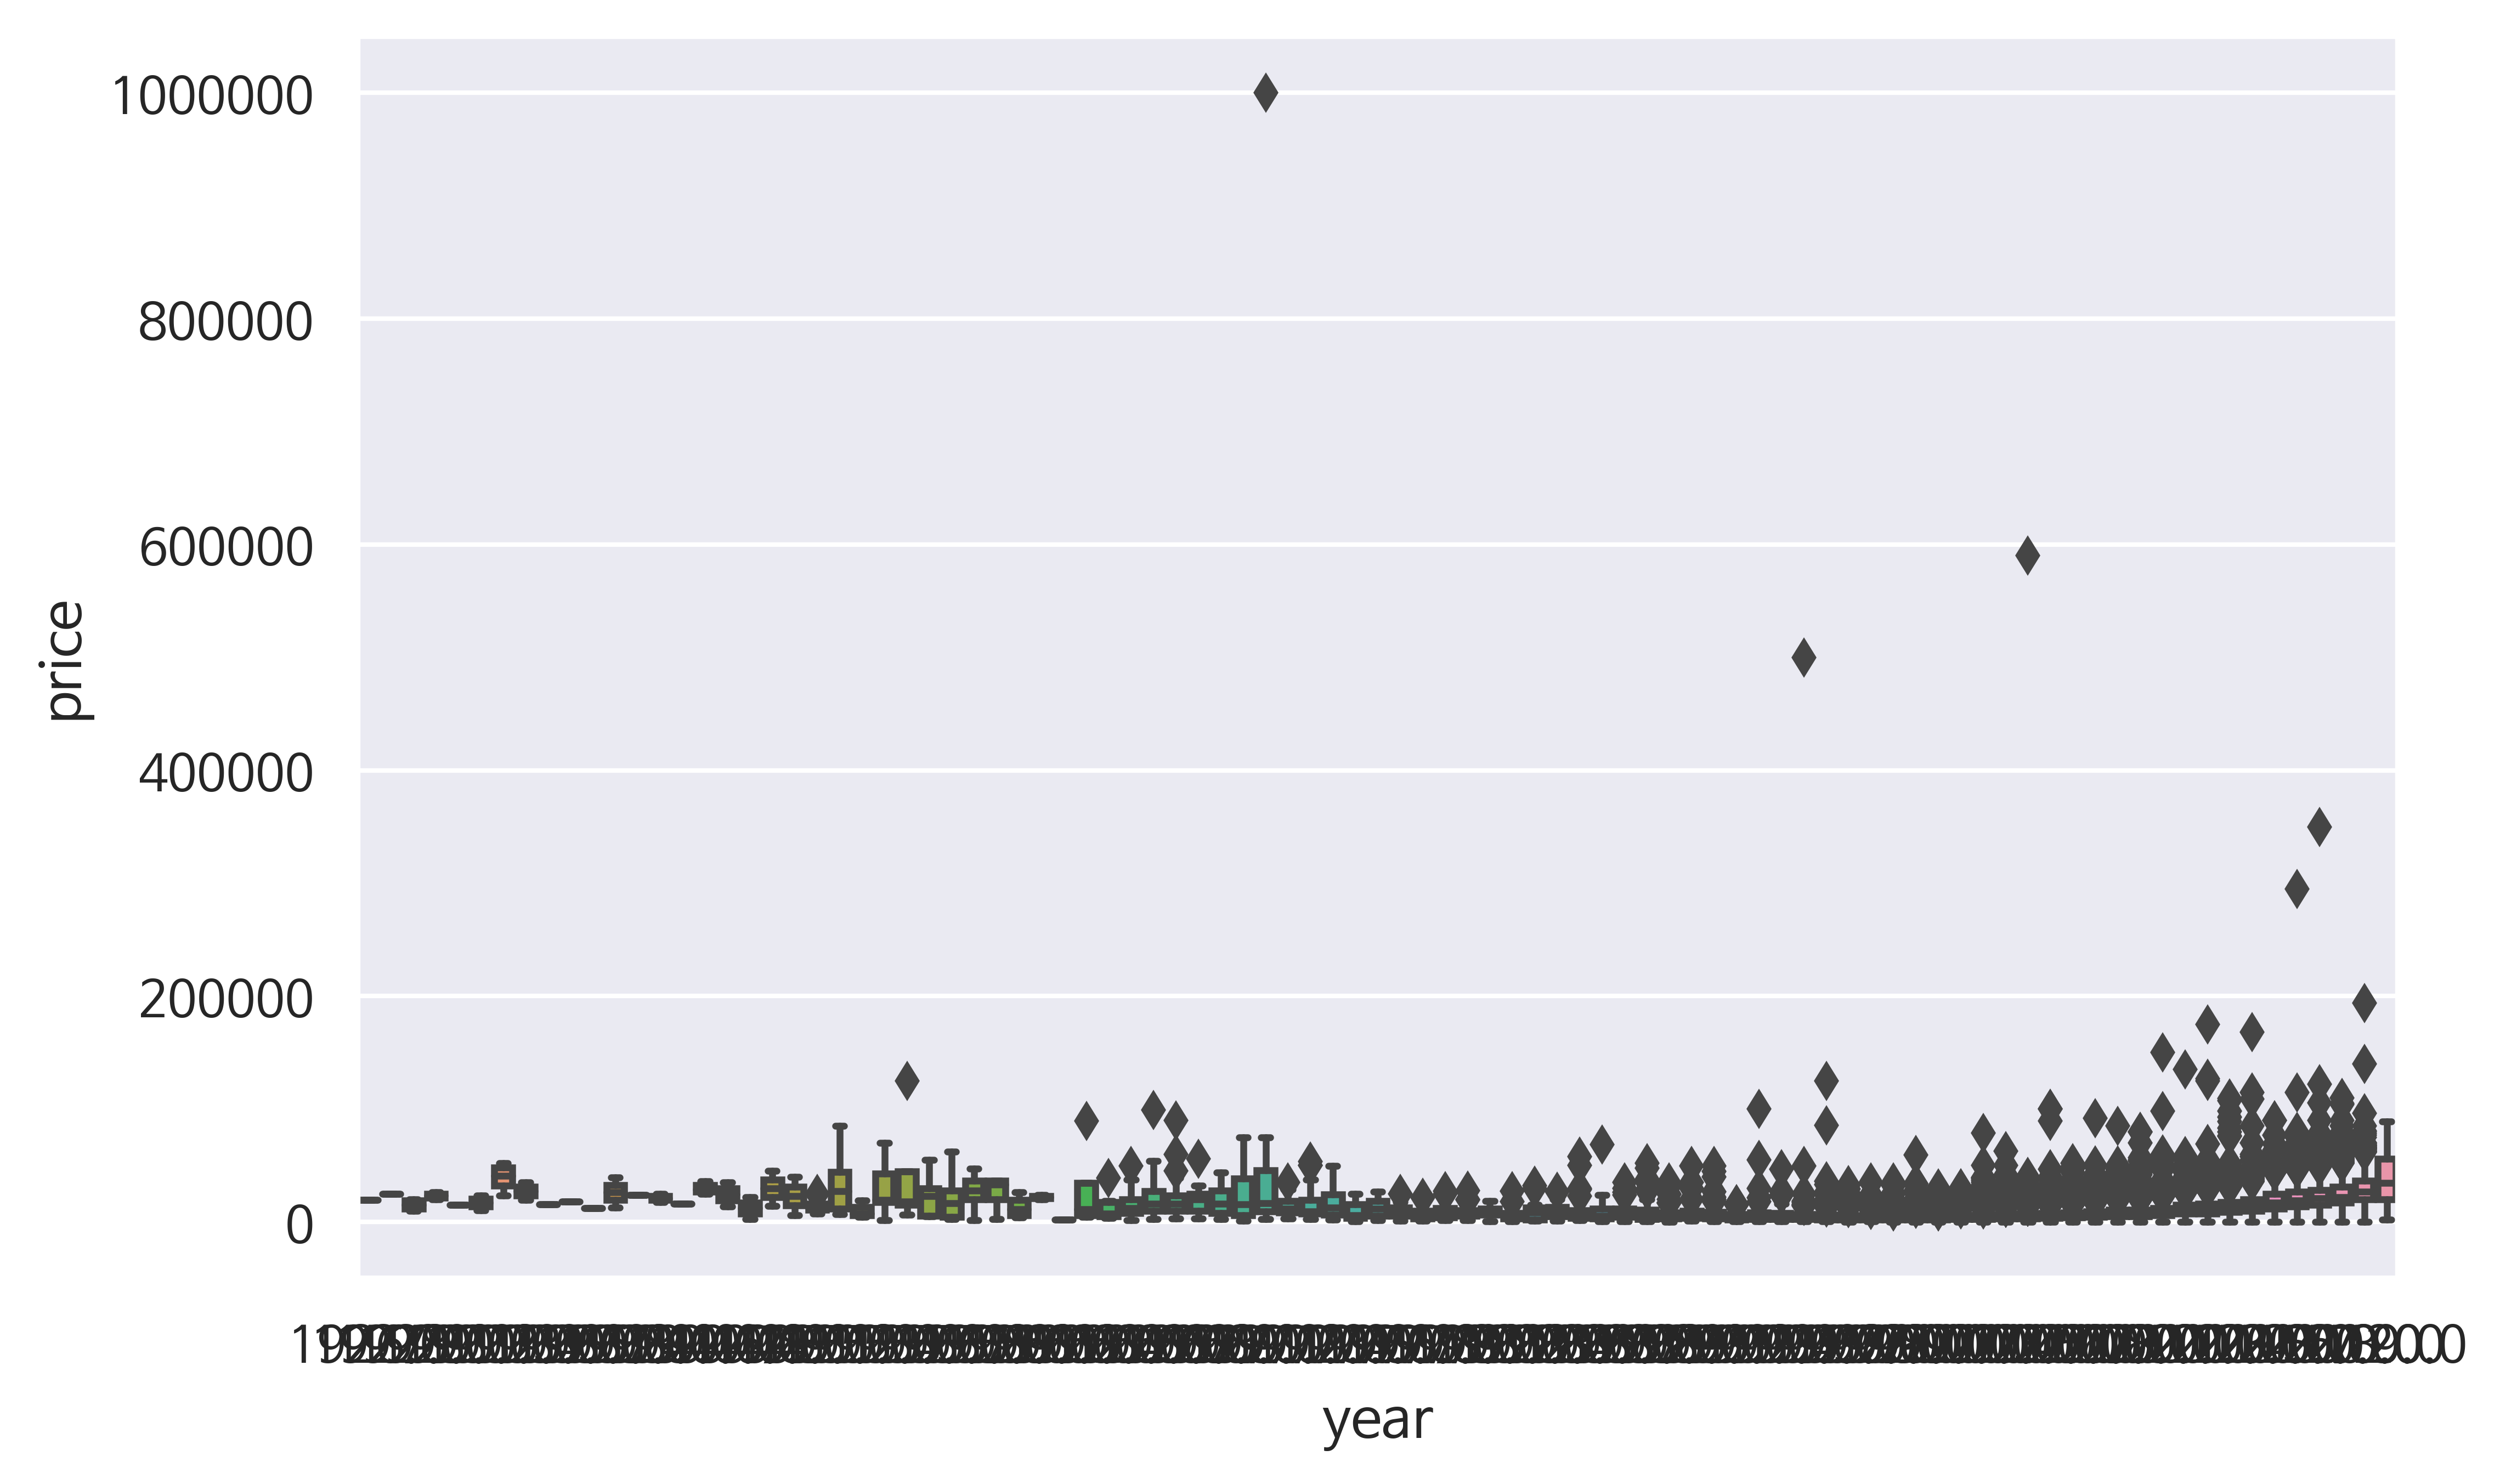

In [205]:
sns.boxplot(x=df['year'],y=df['price'],data=df)

In [237]:
# 10만불 미만

In [333]:
# 10만불 이상 100만불 이하
under_one_mil = df[(df['price'] >= 100000) & (df['price'] <= 1000000)].sort_values(by=['price'],ascending=False)

In [334]:
# 26건
under_one_mil

,id,price,year,odometer,drive,fuel,manufacturer,state,title_status,transmission,type,paint_color,cylinders,model,vin
64504,7049736662,1000000,1970.00,195000.00,rwd,gas,volkswagen,az,salvage,manual,coupe,blue,4 cylinders,beetle,D0330181080013
163001,7047186613,590000,2004.00,159721.00,fwd,gas,lexus,fl,clean,automatic,SUV,silver,6 cylinders,rx330,GA31UX4C016048
447631,7048038726,500000,1994.00,186177.00,rwd,gas,mercedes-benz,pa,salvage,automatic,sedan,brown,6 cylinders,benz,WDBEA929E9F286519
379223,7047780521,350000,2017.00,190000.00,4wd,gas,jeep,ny,clean,automatic,SUV,white,6 cylinders,grand cherokee trail hok,1C4RJFLG7HC667688
317193,7041390316,295000,2016.00,32032.00,fwd,gas,mercedes-benz,mt,clean,automatic,SUV,black,6 cylinders,gle 350 4matic,4JGDA5HB6GA625276
401243,7045671330,193982,2019.00,7584.00,4wd,gas,mercedes-benz,oh,clean,automatic,SUV,white,8 cylinders,amg g 63,WDCYC7HJ3KX301396
171840,7048248566,175000,2012.00,61679.00,rwd,gas,nissan,fl,clean,automatic,truck,silver,8 cylinders,titan crew cab,1N6BA0ED4CN300582
489491,7049122510,168000,2014.00,33755.00,4wd,gas,ford,tx,clean,automatic,van,white,10 cylinders,e350 van,1FBSS3BS8EDA39989
182547,7040863555,149995,2010.00,95878.00,4wd,gas,honda,fl,clean,automatic,truck,blue,6 cylinders,ridgeline rtl,5FPYK1F58AB006970
199725,7048009986,139995,2019.00,649.00,4wd,hybrid,bmw,hi,clean,automatic,convertible,grey,3 cylinders,i8,WBY2Z6C52KVB82784


### 정상적인 가격을 보이는 모델
- 2019 :  i8 bmw , 
- 2017 :  r8 v10 audi , 
- 2014 : california ferrari, 
- 2016 :  martin rapide s aston-martin, 
- 2018 : amg gt mercedes-benz, 
- 2014 :  458 spider ferrari, 
- 2013 : 458 italia ferrari, 
- 2017 :  sprinter 2500 4x4 mercedes-benz, 
- 2018 : revel / sprinter mercedes-benz, 
- 2018 : amg gt mercedes-benz, 
- 2018 : amg gt mercedes-benz, 
- 2005 : f430 berlinetta f1 ferrari

In [316]:
true_id = [7033472903,7039773014,7049284671,7043599850,7049033507,7036156093,7049707044,7048009986,7041367828,7047810612,7045671330,7047378977]

In [317]:
len(true_id)

12

In [457]:
df = df[(df['price'] < 100000) | df['id'].isin(true_id)]
df['year'] = df['year'].astype('int')
df.shape

(71047, 15)

# 연식

In [446]:
df['year'].value_counts().to_dict()

{2016: 5721,
 2013: 5501,
 2015: 5347,
 2014: 5262,
 2012: 5089,
 2011: 4755,
 2017: 4593,
 2008: 4125,
 2010: 3778,
 2007: 3693,
 2006: 3152,
 2018: 2909,
 2009: 2887,
 2005: 2452,
 2004: 2214,
 2003: 1739,
 2019: 1477,
 2002: 1252,
 2001: 1042,
 2000: 796,
 1999: 600,
 1998: 377,
 1997: 340,
 1996: 213,
 1995: 182,
 1994: 168,
 1993: 120,
 1992: 95,
 1990: 89,
 1991: 78,
 1989: 77,
 1988: 66,
 1987: 62,
 1986: 58,
 2020: 56,
 1984: 35,
 1985: 34,
 1981: 22,
 1983: 22,
 1980: 20,
 1982: 12}

In [442]:
# 10건 이상인 연도를 기준으로 잘랐음
df = df[df['year'] >= 1980]

# 모델 테스트

In [8]:
test = df[df['odometer'] <= 10000]
test.shape

(1503, 15)

In [14]:
test = test[test.columns.difference(['id','vin','model'])]

In [16]:
test = pd.get_dummies(test)

In [30]:
test.tail()

,odometer,price,year,cylinders_10 cylinders,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,drive_4wd,drive_fwd,drive_rwd,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,manufacturer_acura,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_nissan,manufacturer_pontiac,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,state_ak,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wy,title_status_clean,title_status_lien,title_status_missing,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,type_SUV,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
509435,5452.00,8995,2020.00,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
509447,9320.00,9800,2019.00,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
509459,5000.00,28999,2017.00,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
509507,4900.00,31500,2019.00,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
509574,6973.00,24895,2019.00,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [44]:
df.shape

(71061, 15)

In [61]:
X.tail()

,odometer,year,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,drive_fwd,drive_rwd,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_manual,transmission_other,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
509547,49698.00,2016.00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
509548,195000.00,2008.00,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
509551,99990.00,2014.00,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
509555,39457.00,2018.00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
509574,6973.00,2019.00,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
df.shape

(71061, 15)

In [142]:
df.model.describe()

count     71061
unique     9752
top       f-150
freq       1738
Name: model, dtype: object

### linear_model.LinearRegression() 방법

In [145]:
X = df[df.columns.difference(['id','model','vin','price'])]
Y = df['price']
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

test_df = pd.concat([train_y,train_X],axis=1)

model = linear_model.LinearRegression() 
result = model.fit(X_train, Y_train)
predicted = result.predict(X_test)
r2_score(Y_test,predicted)
# plt.scatter(Y_test,predicted)

0.3600813587782994

### sm.OLS 방법

In [95]:
X = df[df.columns.difference(['id','model','vin','price'])]
Y = df['price']
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

test_df = pd.concat([train_y,train_X],axis=1)

model = sm.OLS(X_train, Y_train)
result = model.fit()


# sm.OLS formula 방식

In [191]:
df.shape

(71061, 15)

In [192]:
df = df[df.columns.difference(['id','vin','model'])]

In [203]:
df = df[df['year'] > 2000]

In [209]:
df = df[(df['odometer'] >= 100) &  (df['odometer'] <= 1000000)]

In [217]:
result_list =[]
for i in range(1,10):
    X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns.difference(['price'])], df['price'], test_size = .20, random_state = i)

    test_df = pd.concat([Y_train,X_train],axis=1)

    model = sm.OLS.from_formula("price ~ scale(odometer) + C(year) + {}".format(" + ".join(test_df.columns.difference(['odometer','year','price']))),test_df)
    result = model.fit()
    # print(result.summary())
    predict = result.predict(X_test)
#     result_list.append(r2_score(Y_test,predict))
    print(r2_score(Y_test,predict))

0.7168485851786074
0.6960118990151724
0.7020925713194146
0.6967903114393917
0.6431393020065999
0.7188646419172322
0.6579332271979115
0.6687679150745567
0.7004228852463111


In [ ]:
result_list[]

In [211]:
predict = result.predict(X_test)

In [212]:
r2_score(Y_test,predict)

0.7004228852463111

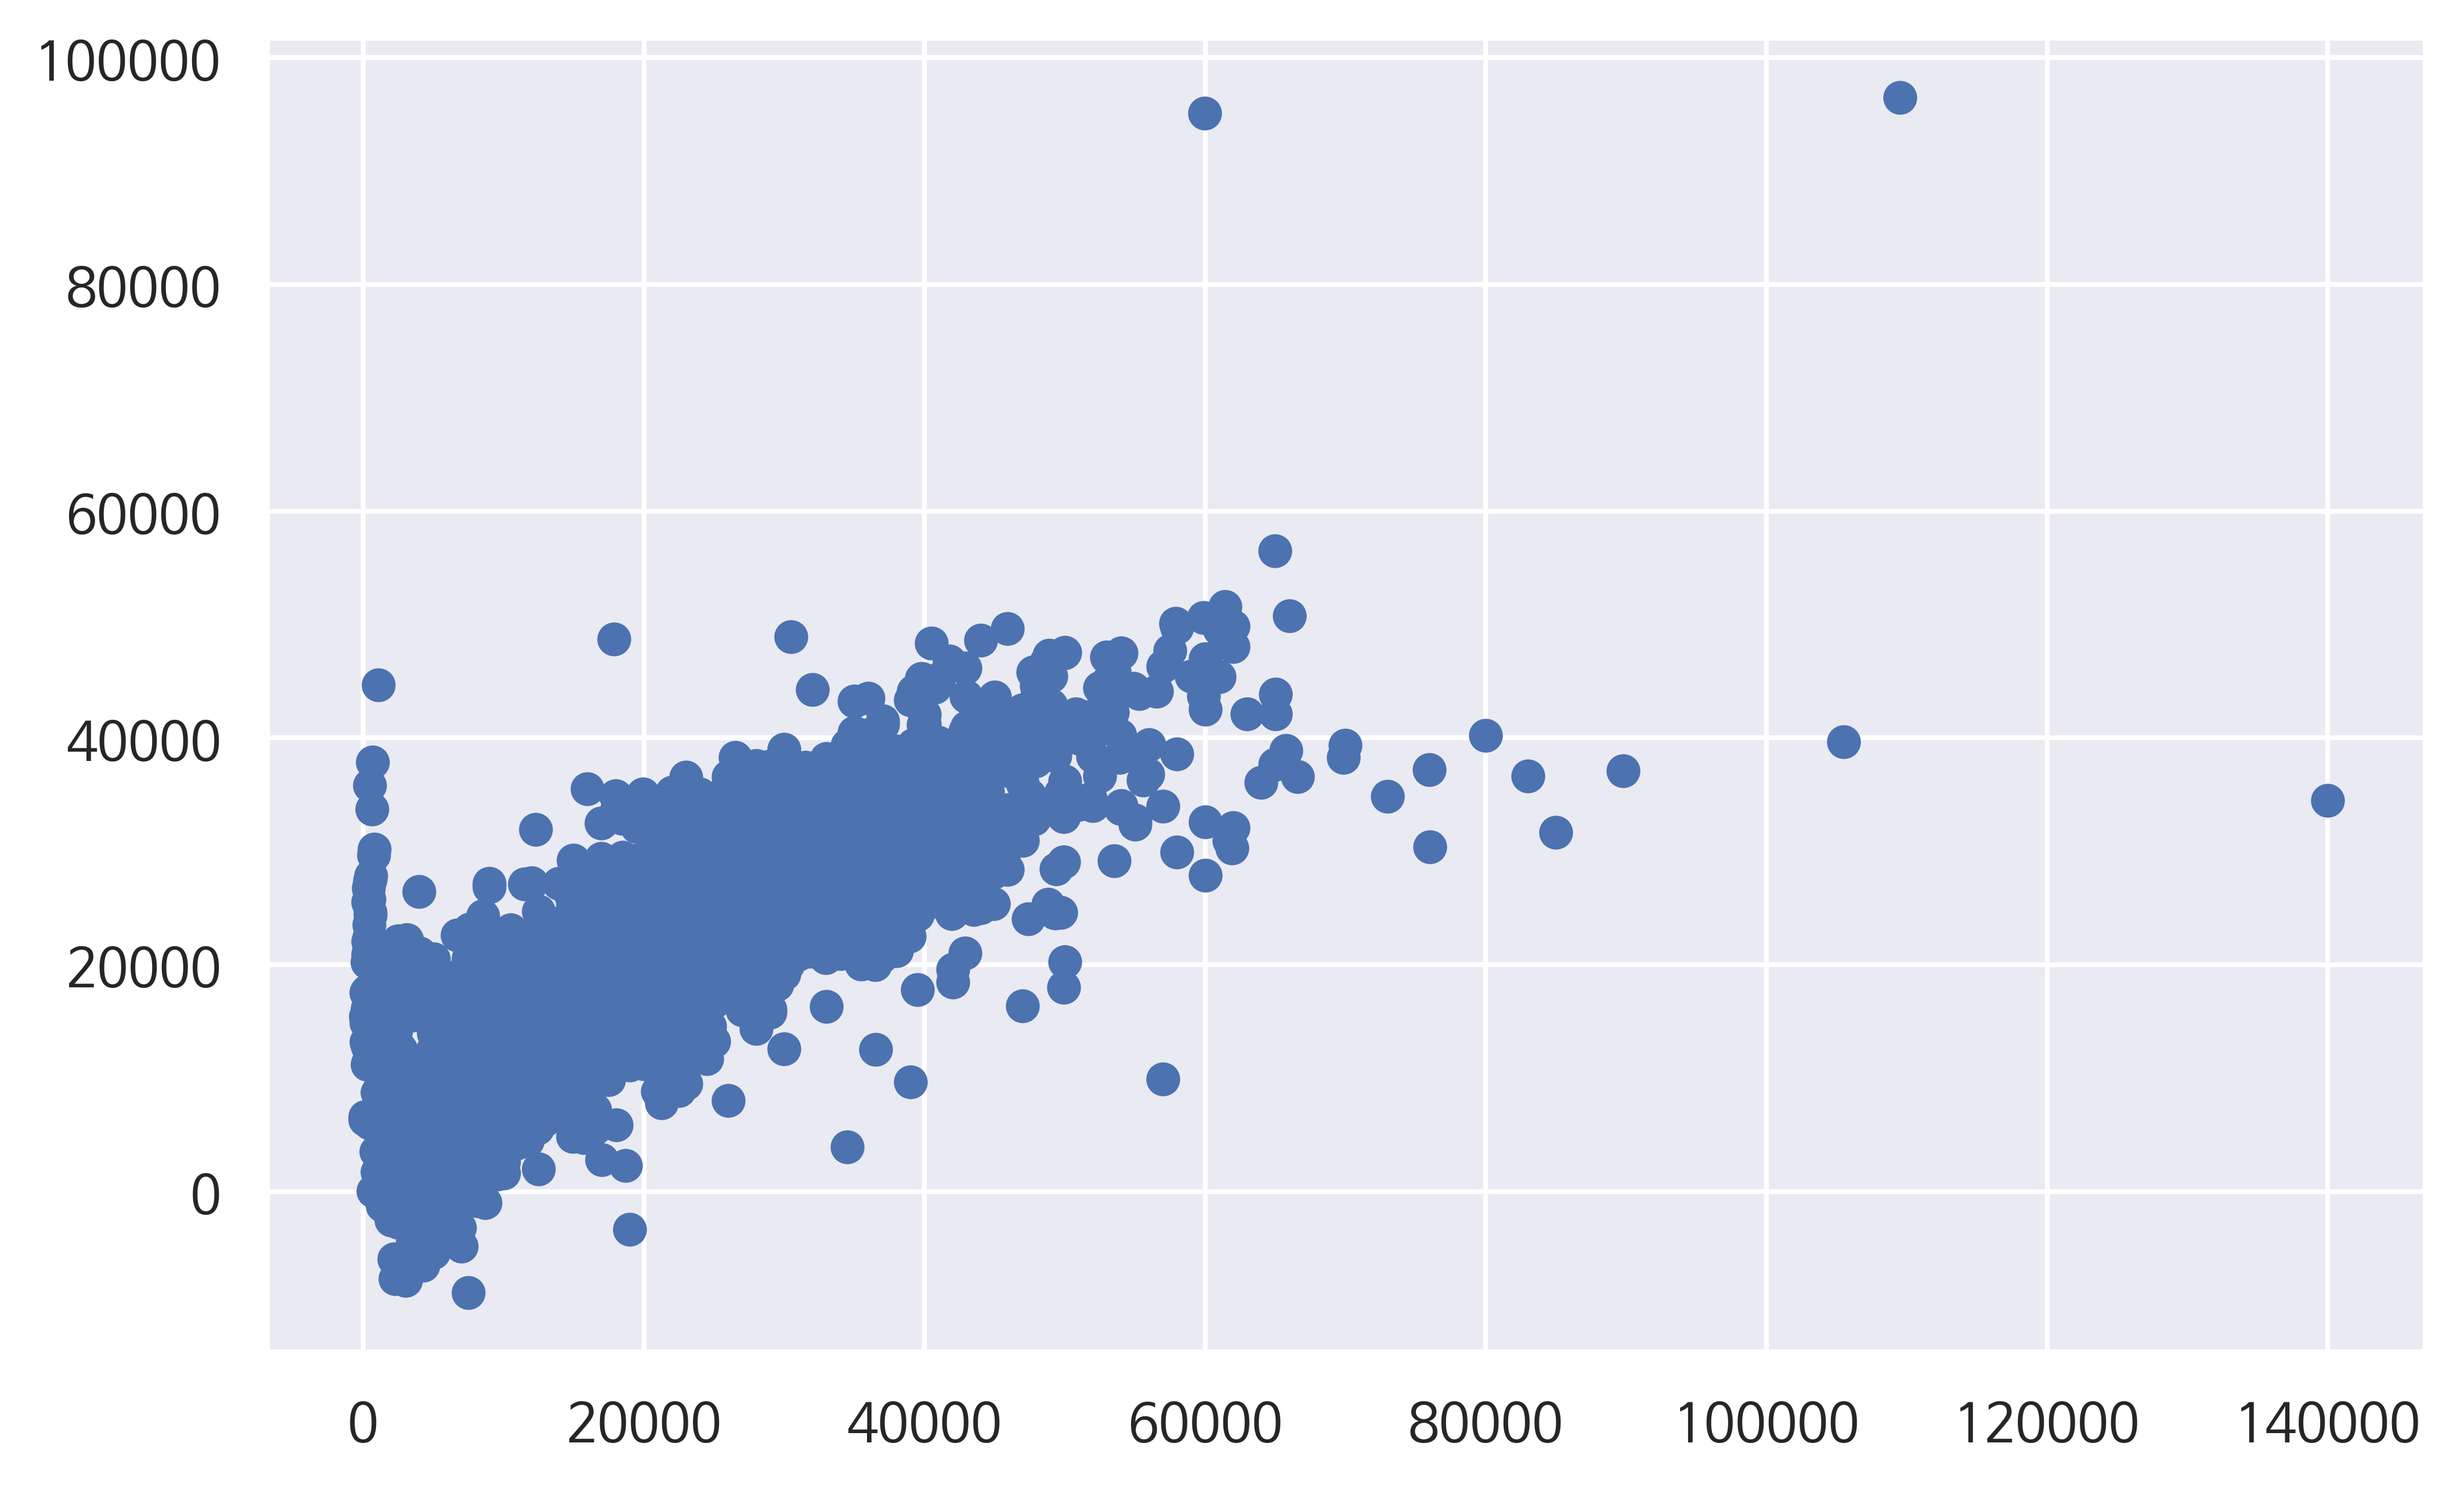

In [213]:
plt.scatter(Y_test,predict)

In [126]:
ls = []
for i in range(0,len(X.columns)):
    ls.append(X.columns[i].replace(' ','_'))

In [128]:
X.columns = ls

In [124]:
X.columns[2].replace(' ','_')

'cylinders_12_cylinders'

In [108]:
.join(test_df.columns.difference(['odometer','year']))

'cylinders_10 cylinders+cylinders_12 cylinders+cylinders_3 cylinders+cylinders_4 cylinders+cylinders_5 cylinders+cylinders_6 cylinders+cylinders_8 cylinders+cylinders_other+drive_4wd+drive_fwd+drive_rwd+fuel_diesel+fuel_electric+fuel_gas+fuel_hybrid+fuel_other+manufacturer_acura+manufacturer_aston-martin+manufacturer_audi+manufacturer_bmw+manufacturer_buick+manufacturer_cadillac+manufacturer_chevrolet+manufacturer_chrysler+manufacturer_datsun+manufacturer_dodge+manufacturer_fiat+manufacturer_ford+manufacturer_gmc+manufacturer_honda+manufacturer_hyundai+manufacturer_infiniti+manufacturer_jaguar+manufacturer_jeep+manufacturer_kia+manufacturer_lexus+manufacturer_lincoln+manufacturer_mazda+manufacturer_mercedes-benz+manufacturer_mercury+manufacturer_mini+manufacturer_mitsubishi+manufacturer_nissan+manufacturer_pontiac+manufacturer_ram+manufacturer_rover+manufacturer_saturn+manufacturer_subaru+manufacturer_toyota+manufacturer_volkswagen+manufacturer_volvo+paint_color_black+paint_color_blue+

In [31]:
train_X, teat_X, train_y, test_y = train_test_split(test[test.columns.difference(['id','model','price','vin'])],test['price'],random_state=7, train_size=0.6)
test_df = pd.concat([train_y,train_X],axis=1)
test_df.shape

(901, 134)

In [43]:
model = sm.OLS.from_formula("scale(price) ~ C(year) + scale(odometer) + {}".format(" + ".join(test_df.columns.difference(['odometer','year']))),test_df)

SyntaxError: invalid syntax (<unknown>, line 1)

In [34]:
model = sm.OLS.from_formula("scale(price) ~ scale(odometer) + C(year) +{}".format("+".join(test_df.columns.difference(['id','price','odometer','year']))),test_df)
# fit = model.fit()
# pred_y = fit.predict(teat_X)
# r2_score(test_y, pred_y)

SyntaxError: invalid syntax (<unknown>, line 1)

In [438]:
result = []
for i in range(1000,100000,1000):
    df = df[df['odometer'] <= i]  
    print(i)
    print(len(df))
    train_X, teat_X, train_y, test_y = train_test_split(df[df.columns.difference(['id','model','price','vin'])],df['price'],random_state=7, train_size=0.7)
    test_df = pd.concat([train_y,train_X],axis=1)
    
    model = sm.OLS.from_formula("scale(price) ~ scale(odometer) + C(year) +{}".format("+".join(test_df.columns.difference(['id','price','odometer','year','vin','model']))),test_df)
    fit = model.fit()
    pred_y = fit.predict(teat_X)
    result.append(r2_score(test_y, pred_y))

1000
285


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 1987 does not match any of the expected levels (expected: [1980, 1984, ..., 2019, 2020])
    scale(price) ~ scale(odometer) + C(year) +cylinders+drive+fuel+manufacturer+paint_color+state+title_status+transmission+type
                                     ^^^^^^^

In [409]:
result

[-0.7204735195964664,
 -0.7204735195964664,
 -0.7204735195964664,
 -0.7204735195964664,
 -0.7204735195964664,
 -0.7204735195964664,
 -0.7204735195964664,
 -0.7204735195964664,
 -0.7204735195964664]

In [395]:
model = sm.OLS.from_formula("scale(price) ~ scale(odometer) + C(year) +{}".format("+".join(test_df.columns.difference(['id','price','odometer','year','vin']))),test_df)
fit = model.fit()

In [399]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           scale(price)   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     815.7
Date:                Thu, 26 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:33:29   Log-Likelihood:                -36538.
No. Observations:               49357   AIC:                         7.343e+04
Df Residuals:                   49182   BIC:                         7.497e+04
Df Model:                         174                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [396]:
pred_y = fit.predict(teat_X)

In [401]:
r2_score(test_y, pred_y)

-1.754296270496345

In [407]:
result_list = []
rows = []
pre_df_len = 0
df[df['odometer'] != 0]
for i in range(1000,10000,1000):
    df = df[df['odometer'] <= i]  
    train_X, teat_X, train_y, test_y = train_test_split(df[df.columns.difference(['id','model','price'])],df['price'], random_state=7, train_size=0.7)
    test_df = pd.concat([train_y,train_X],axis=1)
    if len(test_df) > pre_df_len:
        model = sm.OLS.from_formula("scale(price) ~ scale(odometer) + C(year) +{}".format("+".join(test_df.columns.difference(['id','price','odometer','year','vin','model']))),test_df)
        fit = model.fit()
        pre_df_len = len(test_df)
        
        pred_y = fit.predict(teat_X)
        result = r2_score(test_y, pred_y)
        result_list.append(result)
    else:
        print('범위 : ', i)

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 1987 does not match any of the expected levels (expected: [1980, 1984, ..., 2019, 2020])
    scale(price) ~ scale(odometer) + C(year) +cylinders+drive+fuel+manufacturer+paint_color+state+title_status+transmission+type
                                     ^^^^^^^